AR non-anomaly composites of different variables using different cEOF tests (e.g. DJF, MAM, DJF-MAM). 

Creates a 9 panel plot with the following variables in the columns
1. (upper) 250-hPa geopotential heights (contour lines), isotachs (contour shading), and wind vectors
2. (ivt) 
3. (precip)


## Imports

In [1]:
# Standard Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap, add_subregion_boxes, make_cmap, add_hasia_labels
import nclcmaps as nclc

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text 
rcParams['font.family'] = 'sans-serif'   # font family = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # default sans-serif font = 'Arial'


## Data

In [4]:
# choose season
ssn = 'djfmam'
ceofid = 'HUV500'
neofs = 2 # choose number of eofs
nk = 3 # choose number of clusters

out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
fig_path = path_to_figs + ceofid + '/' + ssn + '/'+ 'neof' + str(neofs) + '/k' + str(nk) + '/'

In [5]:
# import configuration file for dictionary choice
yaml_doc = '../data/config.yml'

config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
#select dictionaries - choose var, anom/nanom, and season
# upper_ precip_ ivt_ and non_anom anom
plot_dict_upper = config['upper_non_anom']
plot_dict_ivt = config['ivt_non_anom']
plot_dict_prec = config['precip_non_anom']

plot_dicts = [plot_dict_upper, plot_dict_ivt, plot_dict_prec]

# djf_dict mam_dict djfmam_dict
ar_dict = config[ssn]

### ERA5 renalysis

In [6]:
def preprocess(ds):
    '''keep only selected lats and lons'''
    if plot_dict['name'] == 'huv250':
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), level=plot_dict['lev'])
    else:
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))
    return subset

f = []
# # Select lat/lon grid
# lonmin = plot_dicts[1]['bnds'][0]
# lonmax = plot_dicts[1]['bnds'][1]
# latmin = plot_dicts[1]['bnds'][2]
# latmax = plot_dicts[1]['bnds'][3]

# Select lat/lon grid
lonmin = 20
lonmax = 110
latmin = 0
latmax = 55

    
for p, plot_dict in enumerate(plot_dicts):

    # # open data  
    f.append(xr.open_mfdataset(path_to_data + plot_dict['fname'] , preprocess=preprocess, combine='by_coords'))


In [7]:
var_dict = {'H': (['time', 'lat', 'lon'], (f[0]['z'].values/(9.80665))), # convert to geopotential height (m)
            'U': (['time', 'lat', 'lon'], f[0]['u'].values),
            'V': (['time', 'lat', 'lon'], f[0]['v'].values),
            'ivte': (['time', 'lat', 'lon'], f[1]['p71.162'].values),
            'ivtn': (['time', 'lat', 'lon'], f[1]['p72.162'].values)}


ds1 = xr.Dataset(var_dict,
                coords={'time': (['time'], f[0]['time'].values),
                        'lat': (['lat'], f[0]['latitude'].values),
                        'lon': (['lon'], f[0]['longitude'].values)})

ds2 = xr.Dataset({'prec': (['time', 'lat', 'lon'], f[2]['mtpr'].values*86400)},
                coords={'time': (['time'], f[2]['time'].values),
                        'lat': (['lat'], f[2]['latitude'].values),
                        'lon': (['lon'], f[2]['longitude'].values)})
ds1
print('ds size in GB {:0.2f}\n'.format(ds1.nbytes / 1e9))

ds_lst = [ds1, ds2]


KeyboardInterrupt



### AR days

In [ ]:
filepath = out_path + 'AR-types_ALLDAYS.csv'
df = pd.read_csv(filepath)

df

In [ ]:
for i, ds in enumerate(ds_lst):
    # Trim date range
    idx = slice(ar_dict['start_date'], ar_dict['end_date'])
    ds = ds.sel(time=idx)
    
    # Select months
    if ar_dict['mon_s'] > ar_dict['mon_e']:
        idx = (ds.time.dt.month >= ar_dict['mon_s']) | (ds.time.dt.month <= ar_dict['mon_e'])
    else:
        idx = (ds.time.dt.month >= ar_dict['mon_s']) & (ds.time.dt.month <= ar_dict['mon_e'])
    ds = ds.sel(time=idx)
    
    # Combine AR Cat data w/ reanalysis data
    # Add ar time series to the ERA dataset
    ds['ar'] = ('time', df.AR_CAT)
    ds = ds.set_coords('ar')
    
    ds_lst[i] = ds

In [ ]:
def select_ar_days(era, lag=0):
    # Select only AR days
    idx = (era.ar >= 1)
    # select days with lag shift
    era_ar = era.shift(time=lag).sel(time=idx)
    # print results
    print(era_ar)
    
    return era_ar

### Compute AR Composites

In [ ]:
era_ar_comp = []
for i, ds in enumerate(ds_lst):
    # Lag=0, -2, +2
    era_ar_lag = select_ar_days(era=ds, lag=0)

    # Compute composites of each AR type
    era_ar_comp.append(era_ar_lag.groupby('ar').mean('time'))

### Figures

### Common Plot Properties

In [ ]:
# # write precip composites to data folder
# era_ar_comp[1].to_netcdf(path=path_to_out+'precip_djfmam_h500_eof2_k3.nc', mode = 'w', format='NETCDF4')
era_ar_comp[0].to_netcdf(path=path_to_out+'huv_ivt_djfmam_h500_eof2_k3.nc', mode = 'w', format='NETCDF4')

In [12]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+10,10)
dy = np.arange(latmin,latmax+10,10)

# subregion info 
# [ymin, xmin]
sr_xy = [[65, 30], [75, 25], [85, 20]]
# width of subregion
sr_width = [10, 10, 10]
# height of subregion
sr_height = [10, 10, 10]

# 9-panel plot    
panel_9 = {'nrows': 3,
            'ncols': 2,
            'artype_lst': list(range(1, nk+1)),
            'panel': '9pan'}

# # test plot    
# panel_test = {'nrows': nk,
#             'ncols': 3,
#             'artype_lst': list(range(1, nk+1)),
#             'panel': 'test'+str(neofs)+str(nk)}


panel_dict = panel_9

### Composite Plots

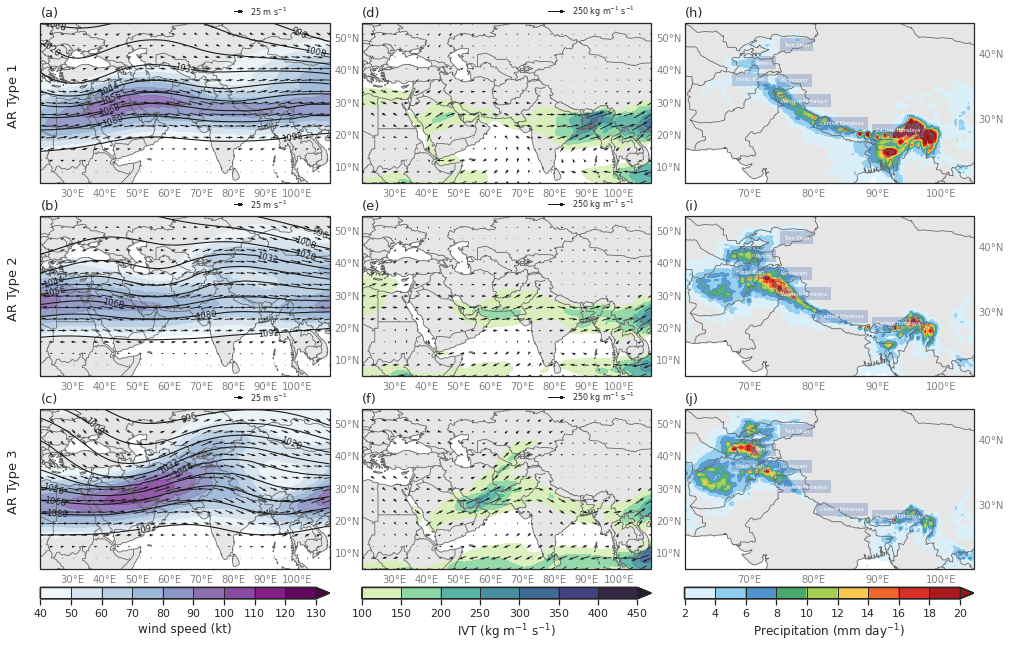

In [45]:
fig_dict = panel_dict
filepath = fig_path + 'composite_' + fig_dict['panel'] + '.png'
nrows = nk
ncols = fig_dict['ncols']
artype_lst = fig_dict['artype_lst']
row_lbl = ['AR Type 1', 'AR Type 2', 'AR Type 3']
col_lbl1 = ['(a)', '(b)', '(c)']
col_lbl2 = ['(d)', '(e)', '(f)']
col_lbl3 = ['(h)', '(i)', '(j)']

ext1 = [20, 110, 5, 55]
ext2 = [60, 105, 20, 45]

# Create figure
fig = plt.figure(figsize=(15,10))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, [0.1, 0.1, 0.66, 0.8], axes_class=axes_class,
                nrows_ncols=(nrows, 2), axes_pad = 0.45,
                cbar_location='bottom', cbar_mode='edge',
                cbar_pad=0.25, cbar_size='7%',label_mode='',
                direction='column',
                aspect=True,
                share_all = False)

axgr2 = AxesGrid(fig, [0.7125, 0.1, 0.33, 0.8], axes_class=axes_class,
                nrows_ncols=(nrows, 1), axes_pad = 0.45,
                cbar_location='bottom', cbar_mode='edge',
                cbar_pad=0.25, cbar_size='7%',label_mode='',
                direction='column',
                aspect=True,
                share_all = False)

#################################
########## UPPER PLOTS ##########
#################################
for k, (ax, ar_type) in enumerate(zip(axgr[0:nrows], artype_lst)):
    data = era_ar_comp[0].sel(ar=ar_type)
    plot_dict = plot_dict_upper
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy, left_lats=False, right_lats=True)
    # Contour Filled

    # 250-hPa Winds (m/s)
    uwnd = data.U.values * units('m/s')
    vwnd = data.V.values * units('m/s')
    wspd = mpcalc.wind_speed(uwnd, vwnd)
    # 250-hPa Winds (knots)
    wspd_kt = wspd.to('kt')
    cflevs = np.arange(plot_dict['cflevs'][0], plot_dict['cflevs'][1], plot_dict['cflevs'][2])
    cf = ax.contourf(lons, lats, wspd_kt, transform=datacrs,
                     levels=cflevs, cmap=plot_dict['cmap'], alpha=0.9, extend='max')
    
    # Contour Lines

    # 250-hPa Heights
    hgts = data.H.values/10. #convert to decimeters
    clevs = np.arange(plot_dict['clevs'][0], plot_dict['clevs'][1], plot_dict['clevs'][2])
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='k', linewidths=1.1)
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)  
        
    # Wind barbs / vectors
    Q = ax.quiver(lons, lats, uwnd, vwnd, transform=datacrs, 
                  color='k', regrid_shape=15, pivot='middle',
                  angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')
    
    # quiver key
    qk = ax.quiverkey(Q, 0.7, 1.07, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                     coordinates='axes', fontproperties={'size': 8.0})
    
    # subtitles
#     plt_label = 'AR Type {0}'.format(ar_type)
    ax.set_title(col_lbl1[k], loc='left',fontsize=13)
    # Row labels
    ax.text(-0.07, 0.55, row_lbl[k], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=ax.transAxes)
    
# Colorbar (single edge)
    cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
    cb.set_label(plot_dict['cb_label'])

################################
########## IVT PLOTS ###########
################################
for k, (ax, ar_type) in enumerate(zip(axgr[nrows:nrows+nrows], artype_lst)):
    data = era_ar_comp[0].sel(ar=ar_type)
    plot_dict = plot_dict_ivt
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy, left_lats=False, right_lats=True)
    # Contour Filled
        
    # IVT (filled contour)
    uvec = data.ivte.values
    vvec = data.ivtn.values
    ivt = np.sqrt(uvec**2 + vvec**2)
    cflevs = np.arange(plot_dict['cflevs'][0], plot_dict['cflevs'][1], plot_dict['cflevs'][2])
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                     levels=cflevs, cmap=plot_dict['cmap'], alpha=0.9, extend='max') 
        
    # Wind barbs / vectors
    Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
                  color='k', regrid_shape=15, pivot='middle',
                  angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')
    
    # quiver key
    qk = ax.quiverkey(Q, 0.7, 1.07, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                          coordinates='axes', fontproperties={'size': 8.0})
    
    # subtitles
    ax.set_title(col_lbl2[k], loc='left',fontsize=13)
    
# Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[1], orientation='horizontal', drawedges=True)
    cb.set_label(plot_dict['cb_label'])

################################
########## PREC PLOTS ##########
################################

for k, (ax, ar_type) in enumerate(zip(axgr2, artype_lst)):
    data = era_ar_comp[1].sel(ar=ar_type)
    plot_dict = plot_dict_prec
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=ext2, xticks=dx, yticks=dy, left_lats=False, right_lats=True)
    # Contour Filled

    # Precip (filled contour)
    cflevs = np.arange(plot_dict['cflevs'][0], plot_dict['cflevs'][1], plot_dict['cflevs'][2])
    cmap = nclc.cmap('WhiteBlueGreenYellowRed')
#     cmap = 'Blues'
    prec = data.prec.values
#     print(prec.min(), prec.max())
    cf = ax.contourf(lons, lats, prec, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='max')
    # add hasia labels
    add_hasia_labels(ax=ax, fntsize=5)
    
    # subtitles
    ax.set_title(col_lbl3[k], loc='left',fontsize=13)
    
# # Colorbar (single)
    cb = fig.colorbar(cf, axgr2.cbar_axes[0], orientation='horizontal', drawedges=True)
    cb.set_label(plot_dict['cb_label'])
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()


In [15]:
clevs = np.arange(100, 275, 50)
clevs

cmap_data = [
             (0, 160, 255), # light blue 200-300
             (230, 220, 50), # yellow 800-900
             (250, 60, 60), # light red 2000-2100
            ]

my_cmap = make_cmap(cmap_data, bit=True)

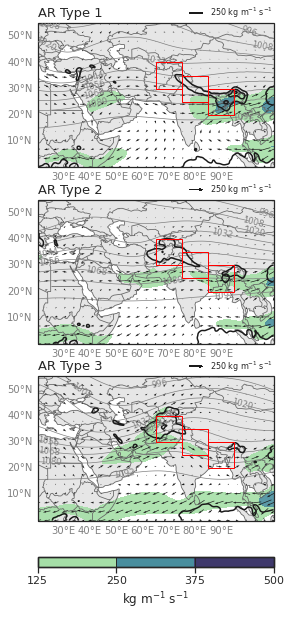

In [16]:
fig_dict = panel_dict
filepath = fig_path + 'composite_schematic.png'
nrows = nk
ncols = 1
artype_lst = fig_dict['artype_lst']

# Create figure
fig = plt.figure(figsize=(15, 10))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.05, cbar_size='7%',label_mode='',
                direction='column')

for k, (ax, ar_type) in enumerate(zip(axgr, artype_lst)):
    data = era_ar_comp[0].sel(ar=ar_type)
    plot_dict = plot_dict_ivt
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Contour Filled
        
    # IVT (filled contour)
    uvec = data.ivte.values
    vvec = data.ivtn.values
    ivt = np.sqrt(uvec**2 + vvec**2)
    ivt_sm = gaussian_filter(ivt, sigma=1.5)
    cflevs = np.arange(125, 510, 125)
    cf = ax.contourf(lons, lats, ivt_sm, transform=datacrs,
                     levels=cflevs, cmap=cmo.deep, alpha=0.9, extend='neither') 
        
    # Wind barbs / vectors
    Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
                  color='k', regrid_shape=17, pivot='middle',
                  angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')
    
    # quiver key
    qk = ax.quiverkey(Q, 0.7, 1.07, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                          coordinates='axes', fontproperties={'size': 8.0})
    
    # Contour Lines
    # 250-hPa Heights
    hgts = data.H.values/10. #convert to decimeters
    clevs = np.arange(840, 1280, 12)
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='grey', linewidths=0.7, linestyles='solid')
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5) 
    
    # Contour Lines
    # Precip
    data = era_ar_comp[1].sel(ar=ar_type)
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values
    prec = data.prec.values
    prec_sm = gaussian_filter(prec, sigma=2.0)
    clevs = np.arange(5, 30, 10)
    cs = ax.contour(lons, lats, prec_sm, transform=datacrs,
                    levels=clevs, colors='k', linewidths=1.5)
    
    
    # subtitles
    plt_label = 'AR Type {0}'.format(ar_type)
    ax.set_title(plt_label, loc='left',fontsize=13)
    # add subregions
    add_subregion_boxes(ax=ax, subregion_xy=sr_xy, width=sr_width, 
                        height=sr_height, ecolor='red', datacrs=datacrs)
    
# Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
    cb.set_label('kg m$^{-1}$ s$^{-1}$')
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()


-7.8888500438017e-07 45.333833926740816
-2.348237464400117e-06 47.688145599244635
-1.350105208838546e-06 43.231417278715426


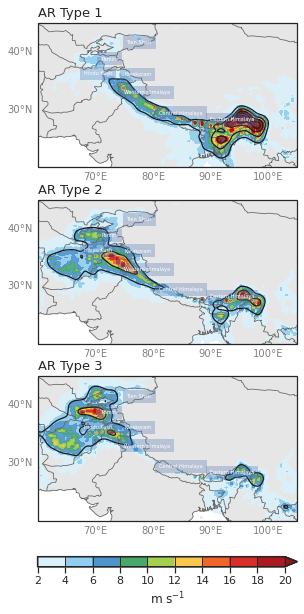

In [17]:
fig_dict = panel_dict
filepath = fig_path + 'composite_precip.png'
nrows = nk
ncols = 1
artype_lst = fig_dict['artype_lst']

# Create figure
fig = plt.figure(figsize=(15, 10))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.05, cbar_size='7%',label_mode='',
                direction='column')

for k, (ax, ar_type) in enumerate(zip(axgr, artype_lst)):
    plot_dict = plot_dict_prec
    # Precip
    data = era_ar_comp[1].sel(ar=ar_type)
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values
    prec = data.prec.values   
    ax = draw_basemap(ax, extent=[60, 105, 20, 45], xticks=dx, yticks=dy)
    
    # Precip (filled contour)
    cflevs = np.arange(plot_dict['cflevs'][0], plot_dict['cflevs'][1], plot_dict['cflevs'][2])
    cmap = nclc.cmap('WhiteBlueGreenYellowRed')
#     cmap = 'Blues'
    prec = data.prec.values
    print(prec.min(), prec.max())
    cf = ax.contourf(lons, lats, prec, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='max')
    # add hasia labels
    add_hasia_labels(ax=ax, fntsize=5)
    
    # Contour Lines
    clevs = np.arange(5, 30, 5)
    prec_sm = gaussian_filter(prec, sigma=2.0)
    cs = ax.contour(lons, lats, prec_sm, transform=datacrs,
                    levels=clevs, colors='k', linewidths=1.25)
    
    
    # subtitles
    plt_label = 'AR Type {0}'.format(ar_type)
    ax.set_title(plt_label, loc='left',fontsize=13)
    
# Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
    cb.set_label('m s$^{-1}$')
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()
